In [9]:
import numpy as np 
import matplotlib.pyplot as plt 

"""
Exercise 2.5 (programming) Design and conduct an experiment to demonstrate the difficulties 
that sample-average methods have for nonstationary problems. Use a modified version of the 
10-armed testbed in which all the q * ( a ) start out equal and then take independent 
random walks (say by adding a normally distributed increment with mean zero and standard 
deviation 0.01 to all the q * ( a ) on each step). Prepare plots like Figure 2.2 
for an action-value method using sample averages, incrementally computed, and another 
action-value method using a constant step-size parameter, α = 0.1. Use ε = 0.1 and longer runs, say of 10,000 steps. 

Sutton, Richard S.,Barto, Andrew G.. Reinforcement Learning, second edition (Adaptive Computation and Machine Learning series) (p. 33). MIT Press. Kindle Edition. 
"""
def RandomWalk(x):
    #x is a vector, each element takes random walk independently, this function return
    # a new vector where each element takes a step by the rule of  random walk
    
    dim = np.size(x)
    
    walk_set=[-1, 1, 0]
    
    for i in range(dim):
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
        x[i]= x[i] + np.random.choice(walk_set)
        
    return x

def eps_greedy(epsilon, Q):
    # This function returns an action chosen by epsilon greedy algorithm given the current action value estimate is Q
    
    # https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
    i = np.argmax(Q)
    
    dim = np.size(Q)
    
    action_space = range(0, dim, 1)
    
    sample = np.random.uniform(0, 1)
    
    if sample <= 1 - epsilon:
        return i
    else:
       action_space = np.delete(action_space, i)
       return np.random.choice(action_space)

Q = [0.2, 0.2, 0.4, 0.2, 0.2]
Q=np.delete(Q, 2)
Q
# eps_greedy(0.5, Q)

array([0.2, 0.2, 0.2, 0.2])

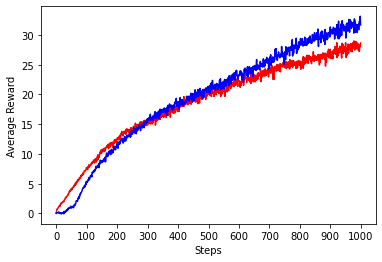

[[ -8  56  14 ...   8  29 -24]
 [-18  -2  10 ... -27 -47   0]
 [ 51  -7  22 ...  21  -2  11]
 ...
 [-30   9 -18 ... -37 -13 -10]
 [ -1 -50  43 ...  -7   6  68]
 [-50 -41 -10 ... -10  -6 -30]]
[[ -4  20   4 ...   3  18  -6]
 [ -7   1   4 ... -11 -32   0]
 [ 46   0   3 ...   2   0   0]
 ...
 [ -6   1 -12 ...  -9   1  -1]
 [  0 -14  39 ...  -6   0  15]
 [-27 -19   0 ...   4   4  -5]]
[[ -9  26   3 ...   0  20 -17]
 [-14   0   5 ...  -8 -46   0]
 [  0   0   0 ...   2  -6   1]
 ...
 [  0   0 -22 ... -13   0   0]
 [  6  -5   3 ... -12   0  22]
 [  0  -8   0 ...   0   0 -10]]


In [13]:

def multi_task(max_iter, # max_iter - circuit braker
               task_number, # rows, samples number
               epsilon, # epsilon - to decide for e-greedy action
               arm_number, # k - in k-armed bandit tasks
               step_size # alpha - step size for updating estimates Q
              ):
    
    rows, cols = task_number, arm_number
    
    my_matrix = np.zeros((rows, cols), dtype=int)
    constQ = np.zeros((rows, cols), dtype=int)
    variaQ = np.zeros((rows, cols), dtype=int)
    q = np.zeros((rows, cols), dtype=int)
    constN =np.zeros((rows, cols), dtype=int)
    variaN = np.zeros((rows, cols), dtype=int)
    
    constR = np.zeros(max_iter)
    variaR = np.zeros(max_iter)
    
    
    for i in range(max_iter): # iterate circuit braker limit number of times
        for j in range(task_number): # foreach in samples/rows
            
            #random walk of each arm
            task_q = q[j,:] # get env rewards for time step j
            task_q = RandomWalk(task_q) # randomize rewards for this time step and each arm out of k arms
            q[j,:] = task_q # store mutated state for j-th time step to persist throughout other experiments until circuit braker limit is reached
            
            # Constant stepsize
            task_constQ = constQ[j,:] # get estimates for this time step stored among experiments
            task_constN = constN[j,:] # get counts of action selections for this time step among experiments
            c = constN[j,:] # get number of actions chosen (array with number in indices of actions)
            action_const = eps_greedy(epsilon, task_constQ) # choose action
            
            reward_const = task_q[action_const] # get reward for chosen action from environmet
            constR[i] = constR[i] + reward_const # aggregate cumulative reward for experiment i
            
            task_constN[action_const] = task_constN[action_const] + 1 # count how many times action was chosen in a given time step
            
            difference = reward_const - task_constQ[action_const] # calculate the difference between environment reward and estimated reward
            alpha = step_size # step size is the same as alpha - constant value
            task_constQ[action_const] = task_constQ[action_const] + alpha * difference # update estimates
            
            constQ[j,:] = task_constQ # update the main matrix to preserve estimates between experiments
            constN[j,:] = task_constN # update the main matrix to preserve counts between experiments
            
            # Changing stepsize
            task_variaQ = variaQ[j,:] # get estimates for this time step stored among experiments
            task_variaN = variaN[j,:] # get counts of action selections for this time step among experiments
            action_varia = eps_greedy(epsilon, task_variaQ) # choose action
            
            reward_varia = task_q[action_varia] # get reward for chosen action from environmet
            task_variaN[action_varia] = task_variaN[action_varia] + 1 # count how many times action was chosen in a given time step
            if i == 0:
                beta = 1 # by convention
            else:
                beta = 1 / task_variaN[action_varia] # classic sampling formula Q = Q + 1/n(R - Q)
            task_variaQ[action_varia] = task_variaQ[action_varia] + beta * (reward_varia - task_variaQ[action_varia]) # Q = Q + 1/n(R - Q)
            
            variaN[j,:] = task_variaN # update the main matrix to preserve estimates between experiments
            variaQ[j,:] = task_variaQ # get counts of action selections for this time step among experiments
            
            variaR[i] = variaR[i] + reward_varia
            
        variaR[i] = variaR[i] / task_number
        constR[i] = constR[i] / task_number
        
        
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.plot(variaR, color='r') # Q = Q + 1/n(R - Q)
    plt.plot(constR, color='b') # Q = Q + alpha*(R - Q)
    plt.xticks(np.arange(0, max_iter+1, 100))
    
    plt.show()
    plt.close()
    print(q)
    print(constQ)
    print(variaQ)

max_iter = 1000
task_number = 500
epsilon = 0.1
arm_number = 10
step_size = 0.1
multi_task(max_iter, task_number, epsilon, arm_number, step_size)

In [12]:
cols = 5
rows = 5
np.zeros((rows, cols), dtype=int), np.array( [([0]*cols) for i in range(rows)] )

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]))